# This notebook is used to generate dataset .csv file for learning.
In Step 1, we extracted video clips and updated the manually labelled data by adding the video clip name. In this step, we will generate the training, valication and test dataset for learning algorithm use.

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

## Read manually labelled data
Previously, we generate dataset from raw video data, which is about 370GB.
* MJ_ButtonPressData_20220401.xlsx: saves all related information where a cyclist pressed the button
* MJ_PassingDistanceData_20220401.xls: saves all related information when a passing happened

To reduce the data size that we need to share and avoid expose identity information, we decide to only share the short video clips around the passing event. This reduce the data to about 55GB.
* OpenSource_PassingDistanceData.csv: saves all related information where a cyclist pressed the button
* OpenSource_ButtonPressData.csv: saves all related information when a passing happened

In [2]:
use_opensource_video_clip = True
if not use_opensource_video_clip:
    # Old way to create training, validation and test dataset without opensource video clips
    root_dir = r"D:\A_Monash_Cyc_Near_Miss_Detection\Victorian_Cycling_data_legacy\MJ"
    Pass_df = pd.read_excel(os.path.join(root_dir, 'MJ_PassingDistanceData_20220401.xls'))
    Press_df = pd.read_excel(os.path.join(root_dir, 'MJ_ButtonPressData_20220401.xlsx'))
else:
    # New way to create dataset with opensourced video clips
    root_dir = r"C:\Users\Lingheng\Documents\git_repo_2023\cyc_near_miss\dataset_utils\dataset_vic_cyc_legacy"
    Pass_df = pd.read_csv(os.path.join(root_dir, 'OpenSource_PassingDistanceData.csv'))
    Press_df = pd.read_csv(os.path.join(root_dir, 'OpenSource_ButtonPressData.csv'))

In [3]:
print(Pass_df.shape)
Pass_df.head()

(18527, 23)


,pass_id,riderid,tripnumber,clipfile,videofile,frameminutes,milliseconds,passdistance,buttonpress,timestamp,...,location_coded,bikelane_coded,parkedcar_coded,eventtype_coded,sign_speed,miss_signspeed,passdistance_coded,passdistance_1m,speedzone_coded,speedzone_collapsed
0,322,1,1,PassingEvent_Duration10s_000322.mp4,Trip_1.3_GP030006.LRV,0:0:12.768,3187733,127.0,NaN,NaN,...,MidBlock,No,Yes,Pass,NaN,1,120-149,>=100cm,NaN,NaN
1,225,1,1,PassingEvent_Duration10s_000225.mp4,Trip_1.1_GP010006.LRV,0:0:13.710,1065833,152.0,NaN,2017-04-10T22:07:43Z,...,MidBlock,Yes,No,Pass,60.0,0,150-199,>=100cm,<=60 km/h,60km/h
2,226,1,1,PassingEvent_Duration10s_000226.mp4,Trip_1.1_GP010006.LRV,0:0:26.818,1078933,189.0,NaN,2017-04-10T22:07:57Z,...,MidBlock,Yes,Yes,Pass,60.0,0,150-199,>=100cm,<=60 km/h,60km/h
3,227,1,1,PassingEvent_Duration10s_000227.mp4,Trip_1.1_GP010006.LRV,0:0:31.21,1083133,140.0,NaN,2017-04-10T22:08:01Z,...,MidBlock,Yes,No,Pass,60.0,0,120-149,>=100cm,<=60 km/h,60km/h
4,323,1,1,PassingEvent_Duration10s_000323.mp4,Trip_1.3_GP030006.LRV,0:0:38.385,3213333,140.0,NaN,NaN,...,MidBlock,No,Yes,Pass,NaN,1,120-149,>=100cm,NaN,NaN


In [4]:
print(Press_df.shape)
Press_df.head()

(224, 19)


,button_press_id,MP_Mannual review of button press footage,RiderId,TripNumber,EventType,clipfile,VideoFile,FrameMinutes,MilliSeconds,PassDistance,ButtonPress,VehicleType,Location,BikeLane,ParkedCar,Review,timestamp,latitude,longitude
0,1,correct,1,1,Pass,ButtonPressEvent_Duration10s_000001.mp4,Trip_1.2_GP020006.LRV,00:11:23,2796433,69.0,Yes,Truck,MidBlock,No,Yes,NaN,NaN,NaN,NaN
1,2,correct,5,3,Pass,ButtonPressEvent_Duration10s_000002.mp4,Trip_3.0_GOPR0023.LRV,00:16:05.760000,950632,51.5,Yes,Bus,MidBlock,Yes,No,NaN,2017-04-23T23:28:52Z,-37.810144,144.969344
2,3,Correct,7,1,Pass,ButtonPressEvent_Duration10s_000003.mp4,Trip_1.0_GOPR0011.LRV,00:01:22.751000,74491,66.0,Yes,Sedan,MidBlock,Yes,Yes,NaN,2017-04-26T07:44:54Z,-37.848510,144.980248
3,4,Correct,7,1,Pass,ButtonPressEvent_Duration10s_000004.mp4,Trip_1.0_GOPR0011.LRV,00:03:34.939000,206591,71.0,Yes,Sedan,MidBlock,No,No,NaN,2017-04-26T07:47:07Z,-37.850776,144.985172
4,5,Correct,7,8,Pass,ButtonPressEvent_Duration10s_000005.mp4,Trip_8.3_GP030020.LRV,00:05:24.857000,3499711,75.0,Yes,Sedan,MidBlock,No,No,NaN,2017-04-30T23:40:54Z,-37.814260,144.971480


## Write extracted information into .csv file for learning algorithm use

In [5]:
use_opensource_video_clip = True
if not use_opensource_video_clip:
    orig_nm_df = pd.DataFrame(columns=['RiderID','TripNumber','VideoName','FramePath','Time','Press','Pass_Distance',
                                       'NearMiss','Seconds','SignedSpeed'])
else:
    orig_nm_df = pd.DataFrame(columns=['RiderID','TripNumber', 'ClipName', 'ClipFramePath', 'VideoName','FramePath','Time','Press','Pass_Distance',
                                       'NearMiss','Seconds','SignedSpeed'])
orig_nm_df.head()

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed


In [6]:
def FindPress(res_rid,res_trip,res_time):
    """
    Find if a rider pressed the button given RiderId, TripNumber, and the time of a pass event.
    Question: there may be multiple video for the same trip, but only compare frameminutes without comapring video? (may problematic)
    """
    res = 0
    sub_df = Press_df[(Press_df['RiderId']==res_rid) & (Press_df['TripNumber']==res_trip)]    # match RiderId and TripNumber
    if len(sub_df) == 0:
        res = 0
        return res
    else:
        for ind,row in sub_df.iterrows():
            t = row['FrameMinutes']
            if isinstance(t, str):
                if len(t.split(':')) ==3:                          # value for Time
                    if len(t.split('.')) > 1:
                        t = datetime.datetime.strptime(t,'%H:%M:%S.%f').time()  
                    else:
                        t = datetime.datetime.strptime(t,'%H:%M:%S').time()  
                elif len(t.split(':')) ==2:
                    t = datetime.datetime.strptime(t,'%M:%S.%f').time()
            
            if res_time.hour == t.hour and res_time.minute == t.minute:
                if res_time.second+0>=t.second and res_time.second-0<=t.second:  # Exactly the same second
                    res=1
                    return res
                else:
                    res = 0
            else:
                res = 0
        return res

In [7]:
def FindNearMiss(row):
    """
    Check if a pass event is a near miss.
    # A passing event is a near miss if:
    #  (1) speed limit is less than or equal to 60 km/h, and passing distance is less than 1m; or
    #  (2) speed limit is greater than 60 km/h, and passing distance is less than 1.5m
    """
    res = 0
    if row['miss_signspeed'] ==1:          # if no speed sign, assume speed limit is 60 km/h
        if row['passdistance'] <= 100:
            res = 1
    else:
        if row['sign_speed'] <= 60 and row['passdistance'] < 100:
            res = 1
        elif row['sign_speed'] > 60 and row['passdistance'] < 150:
            res = 1
        
    return res

### Extract all data

In [8]:
for ind, row in Pass_df.iterrows():
    res_rid = row['riderid']                                             # value for RiderID
    res_trip = row['tripnumber']                                         # value for TripNumber
    num = "%03d" % res_rid
    row_video = row['videofile'].split('\\')[-1]                         # value for VideoName
    row_frame = 'MPDS_'+num+'/'+row['videofile'].split('\\')[-1][:-4]    # value for FramePath
    if len(row['frameminutes'].split(':')) ==3:                          # value for Time
        row_time = datetime.datetime.strptime(row['frameminutes'],'%H:%M:%S.%f').time()  
    elif len(row['frameminutes'].split(':')) ==2:
        row_time = datetime.datetime.strptime(row['frameminutes'],'%M:%S.%f').time()
    row_dp = row['passdistance']                                         # value for Pass_Distance
    row_press = FindPress(res_rid,res_trip,row_time)                     # check if rider pressed button
    row_nm = FindNearMiss(row)                                           # check if the passing event is near miss
    row_seconds = round(row_time.hour*3600+row_time.minute*60+row_time.second+row_time.microsecond/1000000*60)  # Convert time to seconds
    if pd.isna(row['sign_speed']):                                       # if not a value, assume speed is 60 km/h
        row_signspeed = 60.0
    else:
        row_signspeed = row['sign_speed']
        
    # If use opensourced video clips, save clipfile and clipframe to df
    if not use_opensource_video_clip:
        orig_nm_df.loc[ind] = [res_rid,res_trip,row_video,row_frame,row_time,row_press,row_dp,row_nm,row_seconds,row_signspeed]
    else:
        row_clip = row['clipfile']
        row_clip_frame = row['clipfile'].split('.mp4')[0]
        orig_nm_df.loc[ind] = [res_rid,res_trip,row_clip, row_clip_frame, row_video,row_frame,row_time,row_press,row_dp,row_nm,row_seconds,row_signspeed]

orig_nm_df.head()

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed
0,1,1,PassingEvent_Duration10s_000322.mp4,PassingEvent_Duration10s_000322,Trip_1.3_GP030006.LRV,MPDS_001/Trip_1.3_GP030006,00:00:12.768000,0,127.0,0,58,60.0
1,1,1,PassingEvent_Duration10s_000225.mp4,PassingEvent_Duration10s_000225,Trip_1.1_GP010006.LRV,MPDS_001/Trip_1.1_GP010006,00:00:13.710000,0,152.0,0,56,60.0
2,1,1,PassingEvent_Duration10s_000226.mp4,PassingEvent_Duration10s_000226,Trip_1.1_GP010006.LRV,MPDS_001/Trip_1.1_GP010006,00:00:26.818000,0,189.0,0,75,60.0
3,1,1,PassingEvent_Duration10s_000227.mp4,PassingEvent_Duration10s_000227,Trip_1.1_GP010006.LRV,MPDS_001/Trip_1.1_GP010006,00:00:31.210000,0,140.0,0,44,60.0
4,1,1,PassingEvent_Duration10s_000323.mp4,PassingEvent_Duration10s_000323,Trip_1.3_GP030006.LRV,MPDS_001/Trip_1.3_GP030006,00:00:38.385000,0,140.0,0,61,60.0


In [9]:
orig_nm_df[orig_nm_df['NearMiss']==1]

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed
14,1,1,PassingEvent_Duration10s_000320.mp4,PassingEvent_Duration10s_000320,Trip_1.2_GP020006.LRV,MPDS_001/Trip_1.2_GP020006,00:11:23.335000,1,69.0,1,703,60.0
40,1,1,PassingEvent_Duration10s_000224.mp4,PassingEvent_Duration10s_000224,Trip_1.0_GOPR0006.LRV,MPDS_001/Trip_1.0_GOPR0006,00:15:45.267000,0,88.0,1,961,40.0
48,1,1,PassingEvent_Duration10s_000297.mp4,PassingEvent_Duration10s_000297,Trip_1.2_GP020006.LRV,MPDS_001/Trip_1.2_GP020006,00:01:54.756000,0,78.0,1,159,60.0
65,1,1,PassingEvent_Duration10s_000299.mp4,PassingEvent_Duration10s_000299,Trip_1.2_GP020006.LRV,MPDS_001/Trip_1.2_GP020006,00:02:06.764000,0,92.0,1,172,60.0
137,1,3,PassingEvent_Duration10s_000430.mp4,PassingEvent_Duration10s_000430,Trip_3.2_GP020008.LRV,MPDS_001/Trip_3.2_GP020008,00:14:23.360000,0,84.0,1,885,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18471,63,13,PassingEvent_Duration10s_018610.mp4,PassingEvent_Duration10s_018610,Trip_13.0_GOPR0942.LRV,MPDS_063/Trip_13.0_GOPR0942,00:10:07.396000,0,68.0,1,631,50.0
18477,63,13,PassingEvent_Duration10s_018618.mp4,PassingEvent_Duration10s_018618,Trip_13.0_GOPR0942.LRV,MPDS_063/Trip_13.0_GOPR0942,00:14:17.974000,0,85.0,1,915,50.0
18499,63,13,PassingEvent_Duration10s_018609.mp4,PassingEvent_Duration10s_018609,Trip_13.0_GOPR0942.LRV,MPDS_063/Trip_13.0_GOPR0942,00:08:59.751000,0,76.0,1,584,60.0
18501,63,14,PassingEvent_Duration10s_018626.mp4,PassingEvent_Duration10s_018626,Trip_14.0_GOPR1174.LRV,MPDS_063/Trip_14.0_GOPR1174,00:10:00.502000,0,66.0,1,630,50.0


In [11]:
orig_nm_df.to_csv('Orig_NearMiss.csv', index=False)

In [12]:
# Check if data is balanced
orig_nm_df['NearMiss'].value_counts()

0    17185
1     1342
Name: NearMiss, dtype: int64

###  Blance NearMiss and Non-NearMiss data

In [13]:
# Randomize data points
orig_nm_df.sample(frac=1)

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed
11603,41,2,PassingEvent_Duration10s_006491.mp4,PassingEvent_Duration10s_006491,Trip_2.3_GP030041.LRV,MPDS_041/Trip_2.3_GP030041,00:03:19.466000,0,149.5,0,227,40.0
8324,27,6,PassingEvent_Duration10s_008710.mp4,PassingEvent_Duration10s_008710,Trip_6.1_GP012956.LRV,MPDS_027/Trip_6.1_GP012956,00:15:01.196000,0,137.5,0,913,50.0
8312,27,6,PassingEvent_Duration10s_008681.mp4,PassingEvent_Duration10s_008681,Trip_6.0_GOPR2956.LRV,MPDS_027/Trip_6.0_GOPR2956,00:12:55.505000,0,71.5,1,805,60.0
10818,38,4,PassingEvent_Duration10s_011259.mp4,PassingEvent_Duration10s_011259,Trip_4.1_GP012125.LRV,MPDS_038/Trip_4.1_GP012125,00:14:11.750000,0,199.5,0,896,40.0
5510,22,2,PassingEvent_Duration10s_005675.mp4,PassingEvent_Duration10s_005675,Trip_2.1_GP010011.LRV,MPDS_022/Trip_2.1_GP010011,00:08:48.261000,0,202.0,0,544,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5069,21,4,PassingEvent_Duration10s_005369.mp4,PassingEvent_Duration10s_005369,Trip_4.2_GP024706.LRV,MPDS_021/Trip_4.2_GP024706,00:11:02.100000,1,69.0,1,668,60.0
10456,36,6,PassingEvent_Duration10s_010811.mp4,PassingEvent_Duration10s_010811,Trip_6.0_GOPR2964.LRV,MPDS_036/Trip_6.0_GOPR2964,00:07:04.439000,0,137.0,0,450,60.0
12476,45,11,PassingEvent_Duration10s_011983.mp4,PassingEvent_Duration10s_011983,Trip_11.1_GP010033.LRV,MPDS_045/Trip_11.1_GP010033,00:07:56.915000,0,278.0,0,531,40.0
16720,58,10,PassingEvent_Duration10s_016844.mp4,PassingEvent_Duration10s_016844,Trip_10.0_GOPR2994.LRV,MPDS_058/Trip_10.0_GOPR2994,00:12:48.171000,0,245.0,0,778,60.0


In [14]:
# Keep all near miss events, and not near miss but rider pressed button
balanced_nm_df = pd.concat([orig_nm_df[orig_nm_df['NearMiss']==1], orig_nm_df[(orig_nm_df['NearMiss']==0) & (orig_nm_df['Press']==1)]])
print(balanced_nm_df.shape)

(1442, 12)


In [15]:
# Keep 1200 not near miss and rider not pressed button
balanced_nm_df = pd.concat([balanced_nm_df, orig_nm_df[(orig_nm_df['NearMiss']==0) & (orig_nm_df['Press']==0)][:1200]])
print(balanced_nm_df.shape)

(2642, 12)


### Split dataset
* Training: 75%
* Validation: 10%
* Test: 15%

In [16]:
# Use sample to randomize the data
balanced_nm_df = balanced_nm_df.sample(frac=1)
balanced_nm_df

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed
7670,26,4,PassingEvent_Duration10s_007937.mp4,PassingEvent_Duration10s_007937,Trip_4.0_GOPR0008.LRV,MPDS_026/Trip_4.0_GOPR0008,00:05:46.440000,0,92.5,1,372,60.0
1653,9,7,PassingEvent_Duration10s_002240.mp4,PassingEvent_Duration10s_002240,Trip_7.1_GP010109.LRV,MPDS_009/Trip_7.1_GP010109,00:12:42.789000,0,94.5,1,809,50.0
1036,7,6,PassingEvent_Duration10s_001408.mp4,PassingEvent_Duration10s_001408,Trip_6.0_GOPR0017.LRV,MPDS_007/Trip_6.0_GOPR0017,00:08:37.620000,0,165.0,0,554,50.0
7700,26,4,PassingEvent_Duration10s_008071.mp4,PassingEvent_Duration10s_008071,Trip_4.1_GP010008.LRV,MPDS_026/Trip_4.1_GP010008,00:07:08.873000,0,99.5,1,480,60.0
8404,28,1,PassingEvent_Duration10s_008726.mp4,PassingEvent_Duration10s_008726,Trip_1.0_GOPR2113.LRV,MPDS_028/Trip_1.0_GOPR2113,00:05:55.889000,0,92.0,1,408,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8823,30,7,PassingEvent_Duration10s_009208.mp4,PassingEvent_Duration10s_009208,Trip_7.1_GP014721.LRV,MPDS_030/Trip_7.1_GP014721,00:14:56.828000,0,99.0,1,946,60.0
638,2,7,PassingEvent_Duration10s_000192.mp4,PassingEvent_Duration10s_000192,Trip_7.0_GOPR0008.LRV,MPDS_002/Trip_7.0_GOPR0008,00:09:34.780000,0,126.5,0,621,60.0
4754,20,9,PassingEvent_Duration10s_004313.mp4,PassingEvent_Duration10s_004313,Trip_9.0_GOPR0036.LRV,MPDS_020/Trip_9.0_GOPR0036,00:11:44.882000,0,76.0,1,757,50.0
9598,34,5,PassingEvent_Duration10s_010041.mp4,PassingEvent_Duration10s_010041,Trip_5.3_GP033968.LRV,MPDS_034/Trip_5.3_GP033968,00:02:29.316000,0,31.0,1,168,60.0


In [17]:
# Training: 75%, Validation: 1%, Test: 
total_num = len(balanced_nm_df)
train_num = round(total_num*0.75)
val_num = round(total_num*0.1)
test_num = total_num - train_num - val_num
print('Total: {}, Training: {}, Validation: {}, Test: {}'.format(total_num, train_num, val_num, test_num))


Total: 2642, Training: 1982, Validation: 264, Test: 396


In [18]:
split = ['train']*train_num+['val']*val_num+['test']*test_num
balanced_nm_df['Split'] = split
balanced_nm_df

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed,Split
7670,26,4,PassingEvent_Duration10s_007937.mp4,PassingEvent_Duration10s_007937,Trip_4.0_GOPR0008.LRV,MPDS_026/Trip_4.0_GOPR0008,00:05:46.440000,0,92.5,1,372,60.0,train
1653,9,7,PassingEvent_Duration10s_002240.mp4,PassingEvent_Duration10s_002240,Trip_7.1_GP010109.LRV,MPDS_009/Trip_7.1_GP010109,00:12:42.789000,0,94.5,1,809,50.0,train
1036,7,6,PassingEvent_Duration10s_001408.mp4,PassingEvent_Duration10s_001408,Trip_6.0_GOPR0017.LRV,MPDS_007/Trip_6.0_GOPR0017,00:08:37.620000,0,165.0,0,554,50.0,train
7700,26,4,PassingEvent_Duration10s_008071.mp4,PassingEvent_Duration10s_008071,Trip_4.1_GP010008.LRV,MPDS_026/Trip_4.1_GP010008,00:07:08.873000,0,99.5,1,480,60.0,train
8404,28,1,PassingEvent_Duration10s_008726.mp4,PassingEvent_Duration10s_008726,Trip_1.0_GOPR2113.LRV,MPDS_028/Trip_1.0_GOPR2113,00:05:55.889000,0,92.0,1,408,60.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8823,30,7,PassingEvent_Duration10s_009208.mp4,PassingEvent_Duration10s_009208,Trip_7.1_GP014721.LRV,MPDS_030/Trip_7.1_GP014721,00:14:56.828000,0,99.0,1,946,60.0,test
638,2,7,PassingEvent_Duration10s_000192.mp4,PassingEvent_Duration10s_000192,Trip_7.0_GOPR0008.LRV,MPDS_002/Trip_7.0_GOPR0008,00:09:34.780000,0,126.5,0,621,60.0,test
4754,20,9,PassingEvent_Duration10s_004313.mp4,PassingEvent_Duration10s_004313,Trip_9.0_GOPR0036.LRV,MPDS_020/Trip_9.0_GOPR0036,00:11:44.882000,0,76.0,1,757,50.0,test
9598,34,5,PassingEvent_Duration10s_010041.mp4,PassingEvent_Duration10s_010041,Trip_5.3_GP033968.LRV,MPDS_034/Trip_5.3_GP033968,00:02:29.316000,0,31.0,1,168,60.0,test


In [19]:
balanced_nm_df.to_csv('NearMiss_classification.csv',index=False)

### Read near miss dataset

In [37]:
final_nm_df = pd.read_csv('NearMiss_classification.csv')
final_nm_df

,RiderID,TripNumber,ClipName,ClipFramePath,VideoName,FramePath,Time,Press,Pass_Distance,NearMiss,Seconds,SignedSpeed,Split
0,8,7,PassingEvent_Duration10s_1535.mp4,PassingEvent_Duration10s_1535,Trip_7.0_GOPR0021.LRV,MPDS_008/Trip_7.0_GOPR0021,00:07:41.134000,0,191.0,0,469,50.0,train
1,26,4,PassingEvent_Duration10s_7969.mp4,PassingEvent_Duration10s_7969,Trip_4.0_GOPR0008.LRV,MPDS_026/Trip_4.0_GOPR0008,00:09:20.890000,0,98.5,1,613,60.0,train
2,63,1,PassingEvent_Duration10s_18336.mp4,PassingEvent_Duration10s_18336,Trip_1.0_GOPR7384.LRV,MPDS_063/Trip_1.0_GOPR7384,00:09:52.789000,0,91.0,1,639,50.0,train
3,4,5,PassingEvent_Duration10s_1218.mp4,PassingEvent_Duration10s_1218,Trip_5.1_GP010009.LRV,MPDS_004/Trip_5.1_GP010009,00:09:37.832000,0,136.5,0,627,50.0,train
4,50,2,PassingEvent_Duration10s_13822.mp4,PassingEvent_Duration10s_13822,Trip_2.0_GOPR2518.LRV,MPDS_050/Trip_2.0_GOPR2518,00:12:07.754000,1,102.5,0,772,60.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637,55,5,PassingEvent_Duration10s_15500.mp4,PassingEvent_Duration10s_15500,Trip_5.1_GP012155.LRV,MPDS_055/Trip_5.1_GP012155,00:00:05.610000,1,83.0,1,42,50.0,test
2638,2,5,PassingEvent_Duration10s_168.mp4,PassingEvent_Duration10s_168,Trip_5.1_GP010006.LRV,MPDS_002/Trip_5.1_GP010006,00:06:00.989000,0,116.5,0,419,40.0,test
2639,52,7,PassingEvent_Duration10s_14973.mp4,PassingEvent_Duration10s_14973,Trip_7.1_GP010051.LRV,MPDS_052/Trip_7.1_GP010051,00:07:16.559000,1,94.0,1,470,70.0,test
2640,29,6,PassingEvent_Duration10s_8950.mp4,PassingEvent_Duration10s_8950,Trip_6.1_GP012488.LRV,MPDS_029/Trip_6.1_GP012488,00:00:15.324000,0,51.0,1,34,60.0,test


In [38]:
final_nm_df['Press'].value_counts()

0    2416
1     226
Name: Press, dtype: int64

In [39]:
final_nm_df.groupby(['Split','Press']).mean()

RiderID  TripNumber  Pass_Distance  NearMiss     Seconds  \
Split Press                                                               
test  0      19.035813    4.391185     134.264463  0.482094  517.840220   
      1      35.242424    4.454545     109.227273  0.545455  554.696970   
train 0      18.576309    4.467769     130.548485  0.512397  529.525069   
      1      41.538922    5.000000     100.479042  0.562874  557.874251   
val   0      16.315126    4.563025     135.672269  0.466387  490.756303   
      1      28.346154    5.307692     108.057692  0.538462  599.923077   

             SignedSpeed  
Split Press               
test  0        57.768595  
      1        57.878788  
train 0        56.539945  
      1        57.305389  
val   0        56.596639  
      1        58.846154

In [75]:
# Only keep passing event id < 10000 within the small dataset which is only used for test code purpose
keep_row_list = []
for row_i, row in final_nm_df.iterrows():
    event_id = int(row['ClipName'].split('.')[0].split('_')[-1])
    if event_id < 10000:
        keep_row_list.append(row)

In [76]:
tmp_df = pd.DataFrame(keep_row_list)
tmp_df = tmp_df.reset_index()

In [79]:
small_train_df = tmp_df.loc[tmp_df['Split'] == 'train'].sample(75)
small_val_df = tmp_df.loc[tmp_df['Split'] == 'val'].sample(10)
small_test_df = tmp_df.loc[tmp_df['Split'] == 'test'].sample(15)
small_nm_df = pd.concat([small_train_df, small_val_df, small_test_df], ignore_index=True)
small_nm_df.to_csv('NearMiss_classification_small.csv',index=False)

## Plot 

In [2]:
final_nm_df = pd.read_csv('NearMiss_classification.csv')
orig_nm_df = pd.read_csv('Orig_NearMiss.csv')

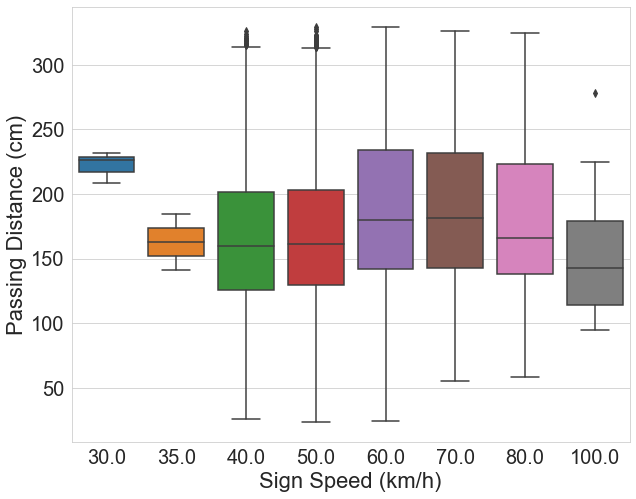

In [3]:
label_fontsize = 20

plt.figure(figsize=(10,8))

sns.set_style("whitegrid")
p = sns.boxplot(x = 'SignedSpeed', y = 'Pass_Distance', data = orig_nm_df)
# plt.setp(p.get_legend().get_texts(), fontsize='20') 
# plt.setp(p.get_legend().get_title(), fontsize='20') 
plt.xticks(fontsize=label_fontsize)
plt.yticks(fontsize=label_fontsize)
p.set_xlabel('Sign Speed (km/h)',fontsize=label_fontsize+2)
p.set_ylabel('Passing Distance (cm)',fontsize=label_fontsize+2)
plt.savefig('boxplot_all.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

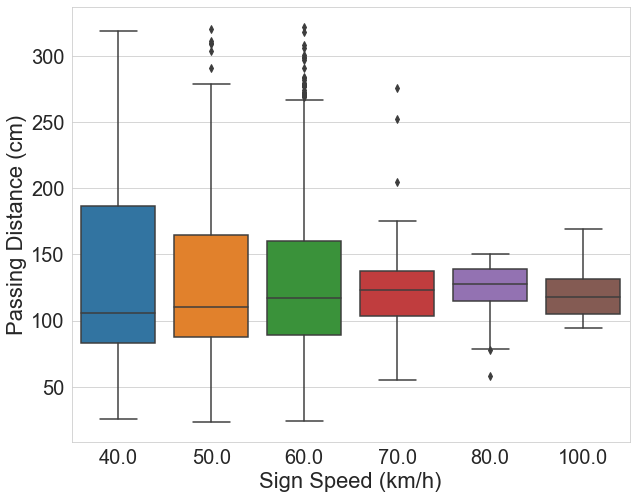

In [4]:
plt.figure(figsize=(10,8))

sns.set_style("whitegrid")
p = sns.boxplot(x = 'SignedSpeed', y = 'Pass_Distance', data = final_nm_df)
# plt.setp(p.get_legend().get_texts(), fontsize='20') 
# plt.setp(p.get_legend().get_title(), fontsize='20') 
plt.xticks(fontsize=label_fontsize)
plt.yticks(fontsize=label_fontsize)
p.set_xlabel('Sign Speed (km/h)',fontsize=label_fontsize+2)
p.set_ylabel('Passing Distance (cm)',fontsize=label_fontsize+2)
plt.savefig('boxplot_our.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

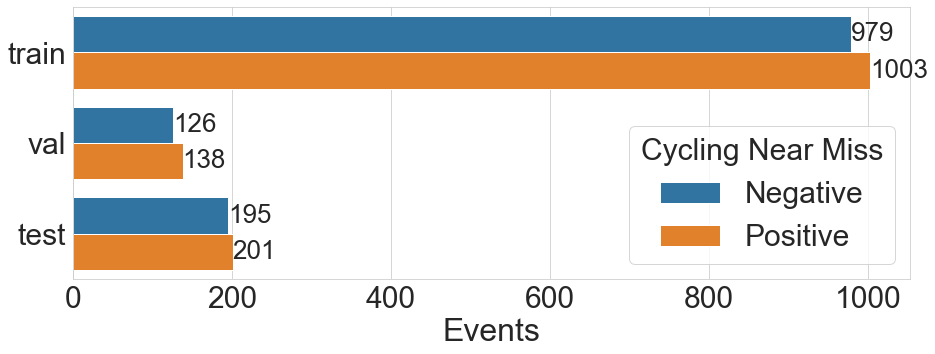

In [5]:
label_fontsize = 30

plt.figure(figsize=(15,5))

sns.set_style("whitegrid")
p = sns.countplot(y = 'Split',hue = 'NearMiss', data = final_nm_df, orient='h')
for container in p.containers:
    p.bar_label(container, fontsize=label_fontsize-4)
# plt.setp(p.get_legend().get_texts(), fontsize='20') 
# plt.setp(p.get_legend().get_title(), fontsize='20')
plt.legend(title='Cycling Near Miss', labels=['Negative', 'Positive'], fontsize=label_fontsize, title_fontsize=label_fontsize)
plt.xticks(fontsize=label_fontsize)
plt.yticks(fontsize=label_fontsize)
p.set_xlabel('Events',fontsize=label_fontsize+2)
p.set_ylabel('',fontsize=label_fontsize+2)

plt.savefig('countnm.png', dpi=150, bbox_inches='tight', pad_inches=0.1)

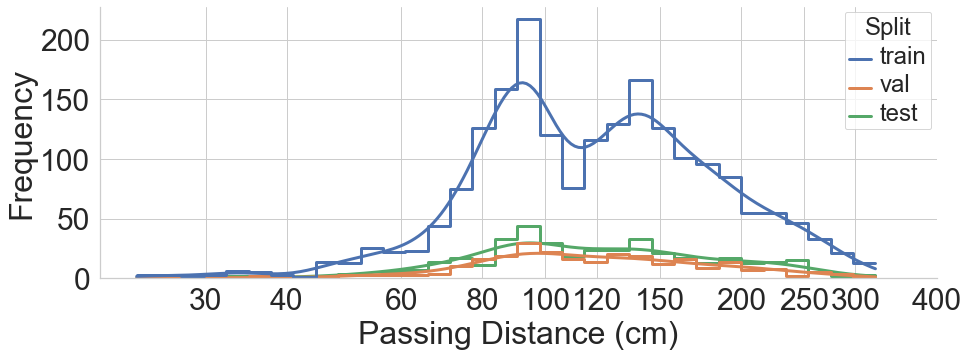

In [27]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

label_fontsize = 30

sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)

sns.histplot(
    final_nm_df,
    x="Pass_Distance", hue="Split",
    linewidth=3,
    kde=True, line_kws={'linewidth': 3},
    log_scale=(True, False),
    element="step", fill=False
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([30, 40, 60, 80,100,120,150,200,250,300,400])

plt.xticks(fontsize=label_fontsize)
plt.yticks(fontsize=label_fontsize)
ax.set_xlabel('Passing Distance (cm)',fontsize=label_fontsize+2)
ax.set_ylabel('Frequency',fontsize=label_fontsize+2)
# plt.legend(fontsize=label_fontsize, title_fontsize=label_fontsize)
plt.setp(ax.get_legend().get_texts(), fontsize=label_fontsize-6) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=label_fontsize-6) # for legend title
plt.savefig('pdhist.png', dpi=150, bbox_inches='tight', pad_inches=0.1)